# Intro

- **Normal graph**: One node type only.
- **Bipartite graph**: Two types of nodes, only edges from one type to the other.


## Projection

- For recovering information across entities of same type, we need to use some math tricks.

In [1]:
import py2neo
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
graph = py2neo.Graph('localhost:7687', user='neo4j', password='test123', encrypted=False)

In [3]:
rows = graph.run(''' 
    MATCH (p:Person) -[:ACTED_IN]-> (m:Movie) RETURN p, m
''').data()

In [4]:
rows[0]

{'p': (_8:Person {born: 1978, name: 'Emil Eifrem'}),
 'm': (_0:Movie {released: 1999, tagline: 'Welcome to the Real World', title: 'The Matrix'})}

In [5]:
rows[0]['p'].keys()

dict_keys(['name', 'born'])

In [6]:
rows[0]['p']['name']

'Emil Eifrem'

In [7]:
rows[0]['p'].labels

:Person

## Graph creation
- Iterate and build the arcs.
- Attach a flag to distinguish the node type.

In [8]:
G = nx.DiGraph()

In [9]:
for row in rows:
    person = row['p']
    movie = row['m']
    G.add_edge(person, movie)
    G.nodes[person]['bipartite'] = 0
    G.nodes[movie]['bipartite'] = 1

In [10]:
# Separate the list of nodes of each type (for projection)
persons = [v for v in G.nodes if G.nodes[v]['bipartite'] == 0]
movies = [v for v in G.nodes if G.nodes[v]['bipartite'] == 1]

In [11]:
# For visualization: separate names and titles
names = { p:p['name'] for p in persons}
titles = { m:m['title'] for m in movies}
labels = { **names, **titles } # Combinations of names and titles

In [12]:
#labels

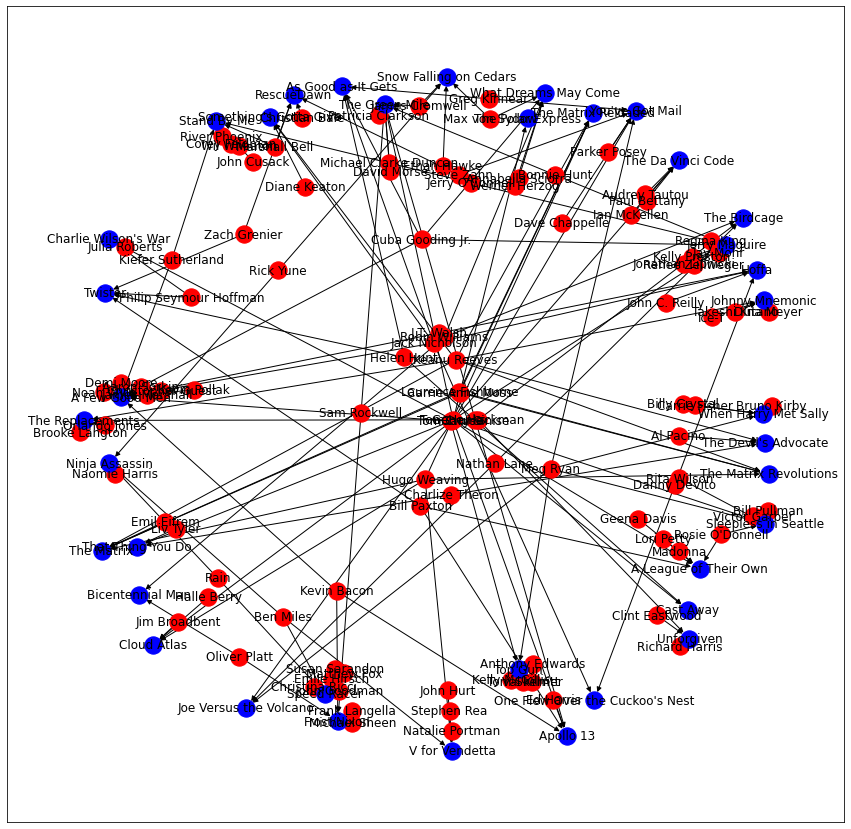

In [13]:
plt.figure(figsize=(15,15))
pos = nx.spring_layout(G)
nx.draw_networkx_edges(G, pos=pos)
nx.draw_networkx_nodes(G, pos=pos, node_color='red', nodelist=persons)
nx.draw_networkx_nodes(G, pos=pos, node_color='blue', nodelist=movies)
nx.draw_networkx_labels(G, pos=pos, labels=labels);

## Projection

- If we care only about relations between films or producers, we make *projection*:
- Projection on films only: 
    - Nodes: films, edges: Edge between *v* and *w* if they have same director (unweighted) 
    - Nodes: films, edges: Edge between *v* and *w* if they have same director, weight is total films in common.
    - Nodes: films, edges: Edge between *v* and *w* if they have same director, weight is films in common / total films between both.

### Example: Simple projection, movies

In [32]:
G_undir = G.to_undirected()
#G_movies = nx.algorithms.bipartite.projected_graph(G_undir, movies)
#G_movies = nx.algorithms.bipartite.weighted_projected_graph(G_undir, movies)
G_movies = nx.algorithms.bipartite.overlap_weighted_projected_graph(G_undir, movies)

In [33]:
weights =  [G_movies.edges[e]['weight'] for e in G_movies.edges]

In [34]:
list(G_movies.edges)[0]

((_0:Movie {released: 1999, tagline: 'Welcome to the Real World', title: 'The Matrix'}),
 (_105:Movie {released: 2012, tagline: 'Everything is connected', title: 'Cloud Atlas'}))

In [35]:
weights[0]

0.125

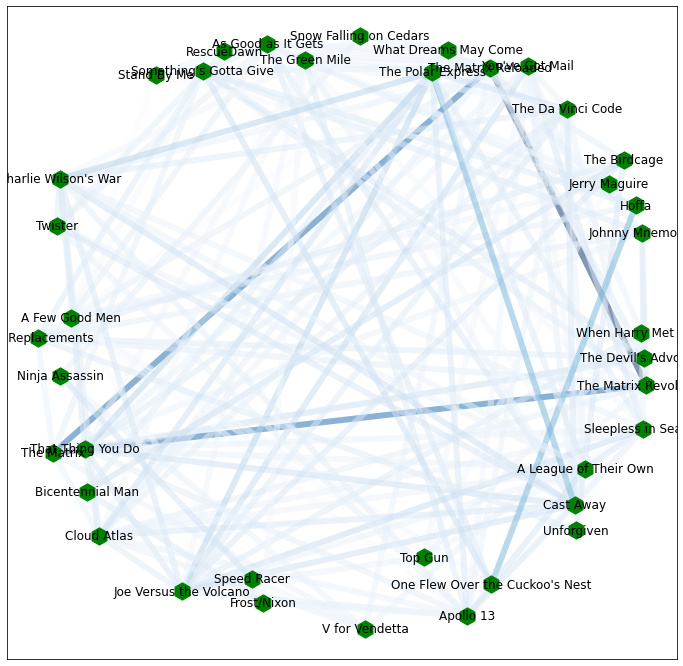

In [37]:
plt.figure(figsize=(12,12))
nx.draw_networkx_edges(G_movies, pos, edge_color=weights, edge_cmap=plt.cm.Blues, width=6, alpha=0.5)
nx.draw_networkx_nodes(G_movies, pos, node_color='green', node_shape='h')
nx.draw_networkx_labels(G_movies, pos, labels=titles);
